# Streamflow Analysis and Visualization

## Introduction
This notebook performs an analysis of streamflow data for various stations over three different periods: 1981-2010, 2026-2055, and 2071-2100. The analysis includes calculating and visualizing the minimum, maximum, and median streamflow values for each period. Additionally, key hydrological metrics such as the Time to Center of Mass (TtCoM), Time to Peak (TtP), and Spring Pulse Onset are computed for each period. The results are visualized using filled plots to highlight the variability and central tendency of streamflow over time.

## Steps
1. **Data Loading and Preprocessing:**
    - Define the input path to the CSV files containing streamflow data.
    - Load the CSV files into a list of DataFrames.
    - Remove spaces from column names to ensure consistency.
    - Concatenate the DataFrames into a single DataFrame with a multi-index.

2. **Data Transformation:**
    - Extract date information from the 'YEAR' and 'JDAY' columns and compute a 'date' column.
    - Add a 'Julian date' column representing the day of the year.
    - Define the start and end dates for three periods: 1981-2010, 2026-2055, and 2071-2100.

3. **Grouping and Aggregation:**
    - Group the data by 'Julian date' and calculate the mean values for each period.
    - Compute the minimum, maximum, and median streamflow values for each station and period.

4. **Metric Calculation:**
    - Define functions to calculate the Time to Center of Mass (TtCoM), Time to Peak (TtP), and Spring Pulse Onset.
    - Apply these functions to the median streamflow values for each period to obtain the metrics.

5. **Visualization:**
    - Create filled plots for each station, showing the minimum, maximum, and median streamflow values for each period.
    - Annotate the plots with the calculated metrics for 1981-2010.
    - Show the differences in the metrics for 2026-2055 and 2071-2100 relative to the baseline period 1981-2010.
    - Save the plots


This notebook processes streamflow data for multiple stations over three distinct periods. The data is aggregated by Julian date to compute the mean streamflow for each day of the year. The minimum, maximum, and median streamflow values are calculated for each station and period. Key hydrological metrics (TtCoM, TtP, Spring Pulse Onset) are computed for the median values. The results are visualized using filled plots to highlight variability and central tendency, with annotations showing the calculated metrics and their differences relative to the baseline period.


If you have any comments, please reach out to Fuad Yassin at fuad.yassin@usask.ca.


In [2]:
import numpy as np

def TtCoM(data, n, days_per_year):
    tpd = 0.0
    ycount = 0
    for i in range(0, n, days_per_year):
        j = min(i + days_per_year, n)
        if np.sum(data[i:j]) > 0.0 and (j - i) > 200:
            tcom = np.sum((np.arange(i, j) - i + 1) * data[i:j]) / np.sum(data[i:j])
            tpd += tcom
            ycount += 1
    ttcom = tpd / ycount
    return ttcom

def TtP(data, n, days_per_year):
    tpd = 0.0
    ycount = 0
    for i in range(0, n, days_per_year):
        j = min(i + days_per_year, n)
        if np.sum(data[i:j]) > 0.0 and (j - i) > 200:
            peak_day = np.argmax(data[i:j]) + 1
            tpd += peak_day
            ycount += 1
    ttp = tpd / ycount
    return ttp

def SpringPulseOnset(data, n, days_per_year):
    spod = 0.0
    ycount = 0
    for i in range(0, n, days_per_year):
        j = min(i + days_per_year, n)
        cum_sum = 0.0
        min_cum_sum = 1.0E38
        onset_day = 0.0
        if np.sum(data[i:j]) > 0.0 and (j - i) > 200:
            mean_val = np.sum(data[i:j]) / (j - i)
            for k in range(i, j):
                cum_sum += (data[k] - mean_val)
                if cum_sum < min_cum_sum:
                    min_cum_sum = cum_sum
                    onset_day = (k % days_per_year) + 1
            spod += onset_day
            ycount += 1
    spring_pulse_onset = spod / ycount
    return spring_pulse_onset

In [14]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from natsort import natsorted
import os

# Define the input path
input_path = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt'
input_path2 = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt'
output_directory = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt/xFigures'
start_dates = [pd.to_datetime('1981-01-01'), pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates = [pd.to_datetime('2010-12-31'), pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]
station_list = ['QOSIM6', 'QOSIM20', 'QOSIM27', 'QOSIM33', 'QOSIM46', 'QOSIM48']
station_names = ['Oldman', 'Bow', 'Red Deer', 'N.SK Edmonton', 'N.SK Prince Albert', 'S.SK Saskatoon']
colors = [[1.00, 0.70, 0.10], [0.70, 0.00, 0.70], [1.00, 0.00, 0.00],[0.70,0.40,0.70],[1.00,0.30,0.00]]

# Create the output directory if it doesn't exist
#output_directory = 'ccstreamflow'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Font size parameters
legend_fontsize = 8
title_fontsize = 10
label_fontsize = 10
annotation_fontsize = 8

# Get list of CSV files from both input paths
csv_files = glob.glob(f"{input_path}/outRunxRExIRxBS**/outRunxRExIRxBS**/BASINAVG1/MESH_output_streamflow.csv")
csv_files = natsorted(csv_files)

csv_files2 = glob.glob(f"{input_path2}/outRunxRExIRxBS**/outRunxRExIRxBS**/BASINAVG1/MESH_output_streamflow.csv")
csv_files2 = natsorted(csv_files2)

# Read CSV files into a list of DataFrames
data_frames = [pd.read_csv(file).replace(-1, np.nan).dropna(axis=1, how='all') for file in csv_files]
data_frames2 = [pd.read_csv(file).replace(-1, np.nan).dropna(axis=1, how='all') for file in csv_files2]

# Remove spaces from column names
for df in data_frames + data_frames2:
    df.columns = df.columns.str.strip()

# Concatenate DataFrames
concatenated_df = pd.concat({f"R{i+1}": df for i, df in enumerate(data_frames)}, axis=1)
concatenated_df2 = pd.concat({f"R{i+1}": df for i, df in enumerate(data_frames2)}, axis=1)

# Remove spaces from MultiIndex column names
concatenated_df.columns = concatenated_df.columns.map(lambda x: (x[0].strip(), x[1].strip()))
concatenated_df2.columns = concatenated_df2.columns.map(lambda x: (x[0].strip(), x[1].strip()))

# Extract date from YEAR and JDAY columns
concatenated_df[('date', 'date')] = pd.to_datetime(concatenated_df[('R1', 'YEAR')], format='%Y') + pd.to_timedelta(concatenated_df[('R1', 'JDAY')] - 1, unit='d')
concatenated_df[('year', 'year')] = concatenated_df[('date', 'date')].dt.year
concatenated_df[('julian_day', 'julian_day')] = concatenated_df[('date', 'date')].dt.dayofyear

concatenated_df2[('date', 'date')] = pd.to_datetime(concatenated_df2[('R1', 'YEAR')], format='%Y') + pd.to_timedelta(concatenated_df2[('R1', 'JDAY')] - 1, unit='d')
concatenated_df2[('year', 'year')] = concatenated_df2[('date', 'date')].dt.year
concatenated_df2[('julian_day', 'julian_day')] = concatenated_df2[('date', 'date')].dt.dayofyear

# Define the periods for the first set of CSV files
start_dates1 = [pd.to_datetime('1981-01-01'), pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates1 = [pd.to_datetime('2010-12-31'), pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]

# Define the periods for the second set of CSV files (lcc)
start_dates2 = [pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates2 = [pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]

# Group by Julian day and calculate the mean for specified periods
df_1981_2010 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[0]) & (concatenated_df[('date', 'date')] <= end_dates1[0])].groupby(('julian_day', 'julian_day')).mean()
df_2026_2055 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[1]) & (concatenated_df[('date', 'date')] <= end_dates1[1])].groupby(('julian_day', 'julian_day')).mean()
df_2071_2100 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[2]) & (concatenated_df[('date', 'date')] <= end_dates1[2])].groupby(('julian_day', 'julian_day')).mean()

df_2026_2055_lcc = concatenated_df2.loc[(concatenated_df2[('date', 'date')] >= start_dates2[0]) & (concatenated_df2[('date', 'date')] <= end_dates2[0])].groupby(('julian_day', 'julian_day')).mean()
df_2071_2100_lcc = concatenated_df2.loc[(concatenated_df2[('date', 'date')] >= start_dates2[1]) & (concatenated_df2[('date', 'date')] <= end_dates2[1])].groupby(('julian_day', 'julian_day')).mean()

# Function to calculate min, max, and median for a given station
def calculate_min_max_median(df, station):
    station_columns = [col for col in df.columns if col[1] == station]
    station_data = df[station_columns]
    min_values = station_data.min(axis=1)
    max_values = station_data.max(axis=1)
    median_values = station_data.median(axis=1)
    return min_values, max_values, median_values

# Calculate metrics for the median values for each period
def calculate_metrics_for_median(median_1981_2010, median_2026_2055, median_2071_2100, median_2026_2055_lcc, median_2071_2100_lcc):
    days_per_year = 366
    
    # Convert medians to numpy arrays for easier indexing
    median_1981_2010 = median_1981_2010.values
    median_2026_2055 = median_2026_2055.values
    median_2071_2100 = median_2071_2100.values
    median_2026_2055_lcc = median_2026_2055_lcc.values
    median_2071_2100_lcc = median_2071_2100_lcc.values
    
    ttcom_1981_2010 = TtCoM(median_1981_2010, len(median_1981_2010), days_per_year)
    ttcom_2026_2055 = TtCoM(median_2026_2055, len(median_2026_2055), days_per_year)
    ttcom_2071_2100 = TtCoM(median_2071_2100, len(median_2071_2100), days_per_year)
    ttcom_2026_2055_lcc = TtCoM(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    ttcom_2071_2100_lcc = TtCoM(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    ttp_1981_2010 = TtP(median_1981_2010, len(median_1981_2010), days_per_year)
    ttp_2026_2055 = TtP(median_2026_2055, len(median_2026_2055), days_per_year)
    ttp_2071_2100 = TtP(median_2071_2100, len(median_2071_2100), days_per_year)
    ttp_2026_2055_lcc = TtP(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    ttp_2071_2100_lcc = TtP(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    spring_pulse_onset_1981_2010 = SpringPulseOnset(median_1981_2010, len(median_1981_2010), days_per_year)
    spring_pulse_onset_2026_2055 = SpringPulseOnset(median_2026_2055, len(median_2026_2055), days_per_year)
    spring_pulse_onset_2071_2100 = SpringPulseOnset(median_2071_2100, len(median_2071_2100), days_per_year)
    spring_pulse_onset_2026_2055_lcc = SpringPulseOnset(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    spring_pulse_onset_2071_2100_lcc = SpringPulseOnset(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    metrics = {
        "1981_2010": {
            "TtCoM": ttcom_1981_2010,
            "TtP": ttp_1981_2010,
            "SpringPulseOnset": spring_pulse_onset_1981_2010,
        },
        "2026_2055": {
            "TtCoM": ttcom_2026_2055,
            "TtP": ttp_2026_2055,
            "SpringPulseOnset": spring_pulse_onset_2026_2055,
            "Diff_TtCoM": ttcom_2026_2055 - ttcom_1981_2010,
            "Diff_TtP": ttp_2026_2055 - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2026_2055 - spring_pulse_onset_1981_2010,
        },
        "2071_2100": {
            "TtCoM": ttcom_2071_2100,
            "TtP": ttp_2071_2100,
            "SpringPulseOnset": spring_pulse_onset_2071_2100,
            "Diff_TtCoM": ttcom_2071_2100 - ttcom_1981_2010,
            "Diff_TtP": ttp_2071_2100 - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2071_2100 - spring_pulse_onset_1981_2010,
        },
        "2026_2055_lcc": {
            "TtCoM": ttcom_2026_2055_lcc,
            "TtP": ttp_2026_2055_lcc,
            "SpringPulseOnset": spring_pulse_onset_2026_2055_lcc,
            "Diff_TtCoM": ttcom_2026_2055_lcc - ttcom_1981_2010,
            "Diff_TtP": ttp_2026_2055_lcc - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2026_2055_lcc - spring_pulse_onset_1981_2010,
        },
        "2071_2100_lcc": {
            "TtCoM": ttcom_2071_2100_lcc,
            "TtP": ttp_2071_2100_lcc,
            "SpringPulseOnset": spring_pulse_onset_2071_2100_lcc,
            "Diff_TtCoM": ttcom_2071_2100_lcc - ttcom_1981_2010,
            "Diff_TtP": ttp_2071_2100_lcc - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2071_2100_lcc - spring_pulse_onset_1981_2010,
        }
    }

    return metrics


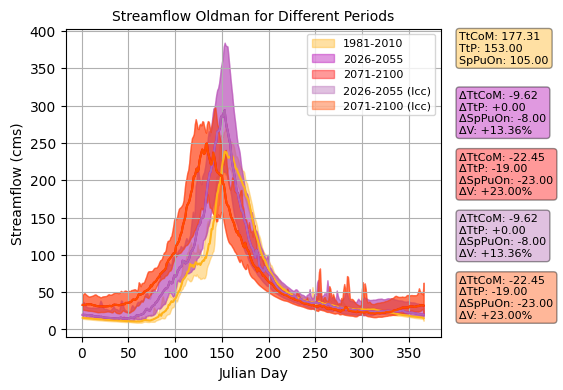

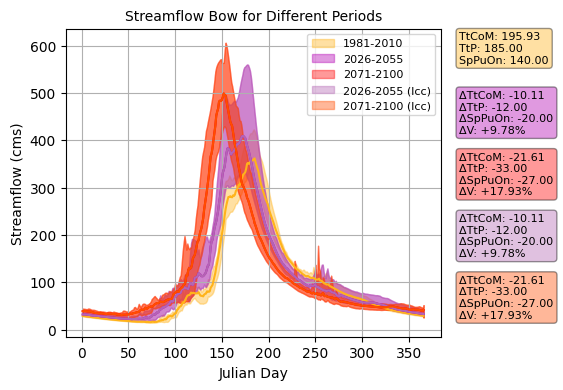

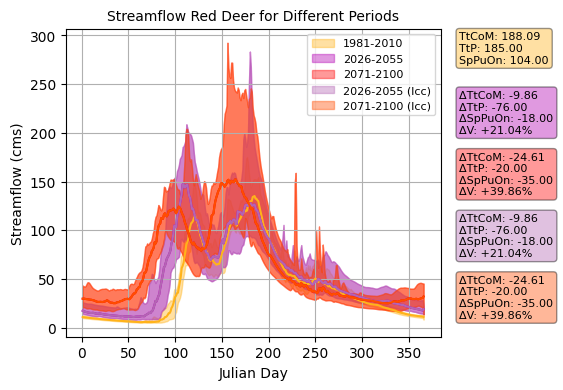

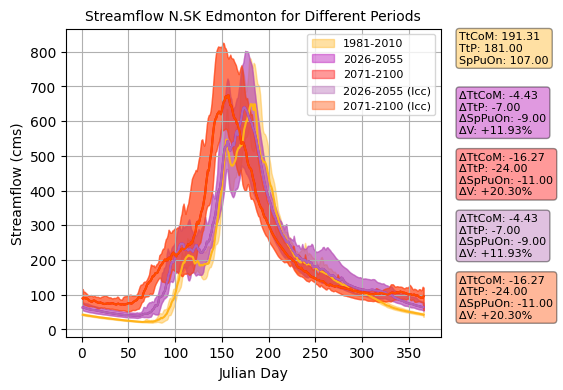

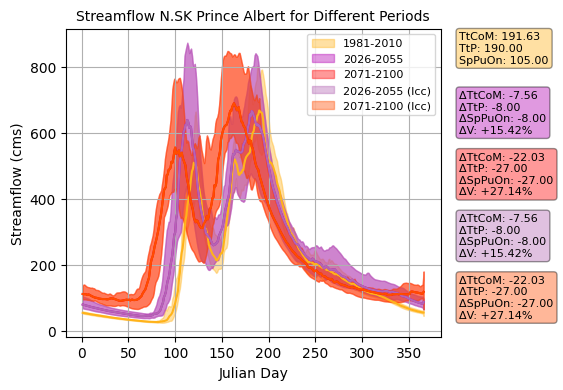

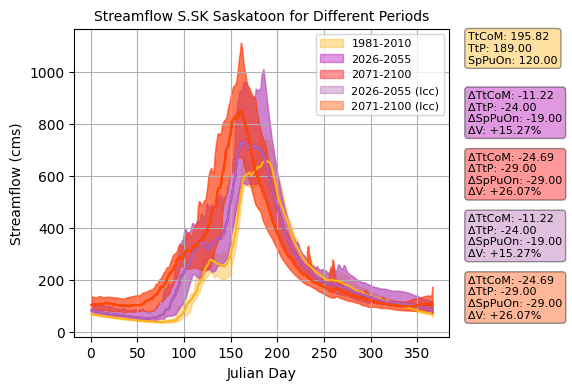

In [16]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from natsort import natsorted
import os

# Define the input path
input_path = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt'
input_path2 = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt'
output_directory = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt/xFigures'
start_dates = [pd.to_datetime('1981-01-01'), pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates = [pd.to_datetime('2010-12-31'), pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]
station_list = ['QOSIM6', 'QOSIM20', 'QOSIM27', 'QOSIM33', 'QOSIM46', 'QOSIM48']
station_names = ['Oldman', 'Bow', 'Red Deer', 'N.SK Edmonton', 'N.SK Prince Albert', 'S.SK Saskatoon']
colors = [[1.00, 0.70, 0.10], [0.70, 0.00, 0.70], [1.00, 0.00, 0.00],[0.70,0.40,0.70],[1.00,0.30,0.00]]

# Create the output directory if it doesn't exist
#output_directory = 'ccstreamflow'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Font size parameters
legend_fontsize = 8
title_fontsize = 10
label_fontsize = 10
annotation_fontsize = 8

# Get list of CSV files from both input paths
csv_files = glob.glob(f"{input_path}/outRunxRExIRxBS**/outRunxRExIRxBS**/BASINAVG1/MESH_output_streamflow.csv")
csv_files = natsorted(csv_files)

csv_files2 = glob.glob(f"{input_path2}/outRunxRExIRxBS**/outRunxRExIRxBS**/BASINAVG1/MESH_output_streamflow.csv")
csv_files2 = natsorted(csv_files2)

# Read CSV files into a list of DataFrames
data_frames = [pd.read_csv(file).replace(-1, np.nan).dropna(axis=1, how='all') for file in csv_files]
data_frames2 = [pd.read_csv(file).replace(-1, np.nan).dropna(axis=1, how='all') for file in csv_files2]

# Remove spaces from column names
for df in data_frames + data_frames2:
    df.columns = df.columns.str.strip()

# Concatenate DataFrames
concatenated_df = pd.concat({f"R{i+1}": df for i, df in enumerate(data_frames)}, axis=1)
concatenated_df2 = pd.concat({f"R{i+1}": df for i, df in enumerate(data_frames2)}, axis=1)

# Remove spaces from MultiIndex column names
concatenated_df.columns = concatenated_df.columns.map(lambda x: (x[0].strip(), x[1].strip()))
concatenated_df2.columns = concatenated_df2.columns.map(lambda x: (x[0].strip(), x[1].strip()))

# Extract date from YEAR and JDAY columns
concatenated_df[('date', 'date')] = pd.to_datetime(concatenated_df[('R1', 'YEAR')], format='%Y') + pd.to_timedelta(concatenated_df[('R1', 'JDAY')] - 1, unit='d')
concatenated_df[('year', 'year')] = concatenated_df[('date', 'date')].dt.year
concatenated_df[('julian_day', 'julian_day')] = concatenated_df[('date', 'date')].dt.dayofyear

concatenated_df2[('date', 'date')] = pd.to_datetime(concatenated_df2[('R1', 'YEAR')], format='%Y') + pd.to_timedelta(concatenated_df2[('R1', 'JDAY')] - 1, unit='d')
concatenated_df2[('year', 'year')] = concatenated_df2[('date', 'date')].dt.year
concatenated_df2[('julian_day', 'julian_day')] = concatenated_df2[('date', 'date')].dt.dayofyear

# Define the periods for the first set of CSV files
start_dates1 = [pd.to_datetime('1981-01-01'), pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates1 = [pd.to_datetime('2010-12-31'), pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]

# Define the periods for the second set of CSV files (lcc)
start_dates2 = [pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates2 = [pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]

# Group by Julian day and calculate the mean for specified periods
df_1981_2010 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[0]) & (concatenated_df[('date', 'date')] <= end_dates1[0])].groupby(('julian_day', 'julian_day')).mean()
df_2026_2055 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[1]) & (concatenated_df[('date', 'date')] <= end_dates1[1])].groupby(('julian_day', 'julian_day')).mean()
df_2071_2100 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[2]) & (concatenated_df[('date', 'date')] <= end_dates1[2])].groupby(('julian_day', 'julian_day')).mean()

df_2026_2055_lcc = concatenated_df2.loc[(concatenated_df2[('date', 'date')] >= start_dates2[0]) & (concatenated_df2[('date', 'date')] <= end_dates2[0])].groupby(('julian_day', 'julian_day')).mean()
df_2071_2100_lcc = concatenated_df2.loc[(concatenated_df2[('date', 'date')] >= start_dates2[1]) & (concatenated_df2[('date', 'date')] <= end_dates2[1])].groupby(('julian_day', 'julian_day')).mean()

# Function to calculate min, max, and median for a given station
def calculate_min_max_median(df, station):
    station_columns = [col for col in df.columns if col[1] == station]
    station_data = df[station_columns]
    min_values = station_data.min(axis=1)
    max_values = station_data.max(axis=1)
    median_values = station_data.median(axis=1)
    return min_values, max_values, median_values

# Calculate metrics for the median values for each period
def calculate_metrics_for_median(median_1981_2010, median_2026_2055, median_2071_2100, median_2026_2055_lcc, median_2071_2100_lcc):
    days_per_year = 366
    
    # Convert medians to numpy arrays for easier indexing
    median_1981_2010 = median_1981_2010.values
    median_2026_2055 = median_2026_2055.values
    median_2071_2100 = median_2071_2100.values
    median_2026_2055_lcc = median_2026_2055_lcc.values
    median_2071_2100_lcc = median_2071_2100_lcc.values
    
    ttcom_1981_2010 = TtCoM(median_1981_2010, len(median_1981_2010), days_per_year)
    ttcom_2026_2055 = TtCoM(median_2026_2055, len(median_2026_2055), days_per_year)
    ttcom_2071_2100 = TtCoM(median_2071_2100, len(median_2071_2100), days_per_year)
    ttcom_2026_2055_lcc = TtCoM(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    ttcom_2071_2100_lcc = TtCoM(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    ttp_1981_2010 = TtP(median_1981_2010, len(median_1981_2010), days_per_year)
    ttp_2026_2055 = TtP(median_2026_2055, len(median_2026_2055), days_per_year)
    ttp_2071_2100 = TtP(median_2071_2100, len(median_2071_2100), days_per_year)
    ttp_2026_2055_lcc = TtP(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    ttp_2071_2100_lcc = TtP(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    spring_pulse_onset_1981_2010 = SpringPulseOnset(median_1981_2010, len(median_1981_2010), days_per_year)
    spring_pulse_onset_2026_2055 = SpringPulseOnset(median_2026_2055, len(median_2026_2055), days_per_year)
    spring_pulse_onset_2071_2100 = SpringPulseOnset(median_2071_2100, len(median_2071_2100), days_per_year)
    spring_pulse_onset_2026_2055_lcc = SpringPulseOnset(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    spring_pulse_onset_2071_2100_lcc = SpringPulseOnset(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    metrics = {
        "1981_2010": {
            "TtCoM": ttcom_1981_2010,
            "TtP": ttp_1981_2010,
            "SpringPulseOnset": spring_pulse_onset_1981_2010,
        },
        "2026_2055": {
            "TtCoM": ttcom_2026_2055,
            "TtP": ttp_2026_2055,
            "SpringPulseOnset": spring_pulse_onset_2026_2055,
            "Diff_TtCoM": ttcom_2026_2055 - ttcom_1981_2010,
            "Diff_TtP": ttp_2026_2055 - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2026_2055 - spring_pulse_onset_1981_2010,
        },
        "2071_2100": {
            "TtCoM": ttcom_2071_2100,
            "TtP": ttp_2071_2100,
            "SpringPulseOnset": spring_pulse_onset_2071_2100,
            "Diff_TtCoM": ttcom_2071_2100 - ttcom_1981_2010,
            "Diff_TtP": ttp_2071_2100 - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2071_2100 - spring_pulse_onset_1981_2010,
        },
        "2026_2055_lcc": {
            "TtCoM": ttcom_2026_2055_lcc,
            "TtP": ttp_2026_2055_lcc,
            "SpringPulseOnset": spring_pulse_onset_2026_2055_lcc,
            "Diff_TtCoM": ttcom_2026_2055_lcc - ttcom_1981_2010,
            "Diff_TtP": ttp_2026_2055_lcc - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2026_2055_lcc - spring_pulse_onset_1981_2010,
        },
        "2071_2100_lcc": {
            "TtCoM": ttcom_2071_2100_lcc,
            "TtP": ttp_2071_2100_lcc,
            "SpringPulseOnset": spring_pulse_onset_2071_2100_lcc,
            "Diff_TtCoM": ttcom_2071_2100_lcc - ttcom_1981_2010,
            "Diff_TtP": ttp_2071_2100_lcc - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2071_2100_lcc - spring_pulse_onset_1981_2010,
        }
    }

    return metrics




# Plotting for each station in station_list
for station, station_name in zip(station_list, station_names):
    min_1981_2010, max_1981_2010, median_1981_2010 = calculate_min_max_median(df_1981_2010, station)
    min_2026_2055, max_2026_2055, median_2026_2055 = calculate_min_max_median(df_2026_2055, station)
    min_2071_2100, max_2071_2100, median_2071_2100 = calculate_min_max_median(df_2071_2100, station)
    min_2026_2055_lcc, max_2026_2055_lcc, median_2026_2055_lcc = calculate_min_max_median(df_2026_2055_lcc, station)
    min_2071_2100_lcc, max_2071_2100_lcc, median_2071_2100_lcc = calculate_min_max_median(df_2071_2100_lcc, station)
    
    metrics_station = calculate_metrics_for_median(median_1981_2010, median_2026_2055, median_2071_2100, median_2026_2055_lcc, median_2071_2100_lcc)
    
    # Calculate the relative change in median volume
    total_volume_1981_2010 = median_1981_2010.sum()
    total_volume_2026_2055 = median_2026_2055.sum()
    total_volume_2071_2100 = median_2071_2100.sum()
    total_volume_2026_2055_lcc = median_2026_2055_lcc.sum()
    total_volume_2071_2100_lcc = median_2071_2100_lcc.sum()
    
    delta_v_2026_2055 = (total_volume_2026_2055 - total_volume_1981_2010) / total_volume_1981_2010 * 100
    delta_v_2071_2100 = (total_volume_2071_2100 - total_volume_1981_2010) / total_volume_1981_2010 * 100
    delta_v_2026_2055_lcc = (total_volume_2026_2055_lcc - total_volume_1981_2010) / total_volume_1981_2010 * 100
    delta_v_2071_2100_lcc = (total_volume_2071_2100_lcc - total_volume_1981_2010) / total_volume_1981_2010 * 100
    
    plt.figure(figsize=(6, 4))

    # Plot for 1981-2010
    plt.fill_between(df_1981_2010.index, min_1981_2010, max_1981_2010, color=colors[0], alpha=0.40, label='1981-2010')
    plt.plot(df_1981_2010.index, median_1981_2010, color=colors[0])

    # Adjust plot margins to make space for annotations
    plt.subplots_adjust(right=0.75)

    # Annotate metrics for 1981-2010
    plt.annotate(f"TtCoM: {metrics_station['1981_2010']['TtCoM']:.2f}\nTtP: {metrics_station['1981_2010']['TtP']:.2f}\nSpPuOn: {metrics_station['1981_2010']['SpringPulseOnset']:.2f}", 
                 xy=(1.05, 0.99), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[0], alpha=0.4))

    # Plot for 2026-2055
    plt.fill_between(df_2026_2055.index, min_2026_2055, max_2026_2055, color=colors[1], alpha=0.40, label='2026-2055')
    plt.plot(df_2026_2055.index, median_2026_2055, color=colors[1])

    # Annotate differences for 2026-2055
    plt.annotate(f"ΔTtCoM: {metrics_station['2026_2055']['Diff_TtCoM']:+.2f}\nΔTtP: {metrics_station['2026_2055']['Diff_TtP']:+.2f}\nΔSpPuOn: {metrics_station['2026_2055']['Diff_SpringPulseOnset']:+.2f}\nΔV: {delta_v_2026_2055:+.2f}%", 
                 xy=(1.05, 0.80), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[1], alpha=0.4))

    # Plot for 2071-2100
    plt.fill_between(df_2071_2100.index, min_2071_2100, max_2071_2100, color=colors[2], alpha=0.40, label='2071-2100')
    plt.plot(df_2071_2100.index, median_2071_2100, color=colors[2])

    # Annotate differences for 2071-2100
    plt.annotate(f"ΔTtCoM: {metrics_station['2071_2100']['Diff_TtCoM']:+.2f}\nΔTtP: {metrics_station['2071_2100']['Diff_TtP']:+.2f}\nΔSpPuOn: {metrics_station['2071_2100']['Diff_SpringPulseOnset']:+.2f}\nΔV: {delta_v_2071_2100:+.2f}%", 
                 xy=(1.05, 0.60), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[2], alpha=0.4))

    # Plot for 2026-2055 (lcc)
    plt.fill_between(df_2026_2055_lcc.index, min_2026_2055_lcc, max_2026_2055_lcc, color=colors[3], alpha=0.40, label='2026-2055 (lcc)')
    plt.plot(df_2026_2055_lcc.index, median_2026_2055_lcc, color=colors[3])

    # Annotate differences for 2026-2055 (lcc)
    plt.annotate(f"ΔTtCoM: {metrics_station['2026_2055_lcc']['Diff_TtCoM']:+.2f}\nΔTtP: {metrics_station['2026_2055_lcc']['Diff_TtP']:+.2f}\nΔSpPuOn: {metrics_station['2026_2055_lcc']['Diff_SpringPulseOnset']:+.2f}\nΔV: {delta_v_2026_2055_lcc:+.2f}%", 
                 xy=(1.05, 0.40), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[3], alpha=0.4))

    # Plot for 2071-2100 (lcc)
    plt.fill_between(df_2071_2100_lcc.index, min_2071_2100_lcc, max_2071_2100_lcc, color=colors[4], alpha=0.40, label='2071-2100 (lcc)')
    plt.plot(df_2071_2100_lcc.index, median_2071_2100_lcc, color=colors[4])

    # Annotate differences for 2071-2100 (lcc)
    plt.annotate(f"ΔTtCoM: {metrics_station['2071_2100_lcc']['Diff_TtCoM']:+.2f}\nΔTtP: {metrics_station['2071_2100_lcc']['Diff_TtP']:+.2f}\nΔSpPuOn: {metrics_station['2071_2100_lcc']['Diff_SpringPulseOnset']:+.2f}\nΔV: {delta_v_2071_2100_lcc:+.2f}%", 
                 xy=(1.05, 0.20), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[4], alpha=0.4))

    plt.xlabel('Julian Day', fontsize=label_fontsize)
    plt.ylabel(f'Streamflow (cms)', fontsize=label_fontsize)
    plt.title(f'Streamflow {station_name} for Different Periods', fontsize=title_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True)
    
    # Save the figure
    plt.savefig(os.path.join(output_directory, f"{station_name}_streamflow.png"), bbox_inches='tight')
    # Display the plot
    plt.show()


In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from natsort import natsorted
import os

# Define the input path
input_path = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt'
input_path2 = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt'
output_directory = '/scratch/fuaday/B0_CanRCM4_Runs/B_Run_noglc_nomgnt/xFigures'
start_dates = [pd.to_datetime('1981-01-01'), pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates = [pd.to_datetime('2010-12-31'), pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]
station_list = ['QOSIM6', 'QOSIM20', 'QOSIM27', 'QOSIM33', 'QOSIM46', 'QOSIM48']
station_names = ['Oldman', 'Bow', 'Red Deer', 'N.SK Edmonton', 'N.SK Prince Albert', 'S.SK Saskatoon']
colors = [[1.00, 0.70, 0.10], [0.70, 0.00, 0.70], [1.00, 0.00, 0.00], [0.70, 0.40, 0.70], [1.00, 0.30, 0.00]]

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Font size parameters
legend_fontsize = 8
title_fontsize = 10
label_fontsize = 10
annotation_fontsize = 8

# Get list of CSV files from both input paths
csv_files = glob.glob(f"{input_path}/outRunxRExIRxBS**/outRunxRExIRxBS**/BASINAVG1/MESH_output_streamflow.csv")
csv_files = natsorted(csv_files)

csv_files2 = glob.glob(f"{input_path2}/outRunxRExIRxBS**/outRunxRExIRxBS**/BASINAVG1/MESH_output_streamflow.csv")
csv_files2 = natsorted(csv_files2)

# Read CSV files into a list of DataFrames
data_frames = [pd.read_csv(file).replace(-1, np.nan).dropna(axis=1, how='all') for file in csv_files]
data_frames2 = [pd.read_csv(file).replace(-1, np.nan).dropna(axis=1, how='all') for file in csv_files2]

# Remove spaces from column names
for df in data_frames + data_frames2:
    df.columns = df.columns.str.strip()

# Concatenate DataFrames
concatenated_df = pd.concat({f"R{i+1}": df for i, df in enumerate(data_frames)}, axis=1)
concatenated_df2 = pd.concat({f"R{i+1}": df for i, df in enumerate(data_frames2)}, axis=1)

# Remove spaces from MultiIndex column names
concatenated_df.columns = concatenated_df.columns.map(lambda x: (x[0].strip(), x[1].strip()))
concatenated_df2.columns = concatenated_df2.columns.map(lambda x: (x[0].strip(), x[1].strip()))

# Extract date from YEAR and JDAY columns
concatenated_df[('date', 'date')] = pd.to_datetime(concatenated_df[('R1', 'YEAR')], format='%Y') + pd.to_timedelta(concatenated_df[('R1', 'JDAY')] - 1, unit='d')
concatenated_df[('year', 'year')] = concatenated_df[('date', 'date')].dt.year
concatenated_df[('julian_day', 'julian_day')] = concatenated_df[('date', 'date')].dt.dayofyear

concatenated_df2[('date', 'date')] = pd.to_datetime(concatenated_df2[('R1', 'YEAR')], format='%Y') + pd.to_timedelta(concatenated_df2[('R1', 'JDAY')] - 1, unit='d')
concatenated_df2[('year', 'year')] = concatenated_df2[('date', 'date')].dt.year
concatenated_df2[('julian_day', 'julian_day')] = concatenated_df2[('date', 'date')].dt.dayofyear

# Define the periods for the first set of CSV files
start_dates1 = [pd.to_datetime('1981-01-01'), pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates1 = [pd.to_datetime('2010-12-31'), pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]

# Define the periods for the second set of CSV files (lcc)
start_dates2 = [pd.to_datetime('2026-01-01'), pd.to_datetime('2071-01-01')]
end_dates2 = [pd.to_datetime('2055-12-31'), pd.to_datetime('2100-12-31')]

# Group by Julian day and calculate the mean for specified periods
df_1981_2010 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[0]) & (concatenated_df[('date', 'date')] <= end_dates1[0])].groupby(('julian_day', 'julian_day')).mean()
df_2026_2055 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[1]) & (concatenated_df[('date', 'date')] <= end_dates1[1])].groupby(('julian_day', 'julian_day')).mean()
df_2071_2100 = concatenated_df.loc[(concatenated_df[('date', 'date')] >= start_dates1[2]) & (concatenated_df[('date', 'date')] <= end_dates1[2])].groupby(('julian_day', 'julian_day')).mean()

df_2026_2055_lcc = concatenated_df2.loc[(concatenated_df2[('date', 'date')] >= start_dates2[0]) & (concatenated_df2[('date', 'date')] <= end_dates2[0])].groupby(('julian_day', 'julian_day')).mean()
df_2071_2100_lcc = concatenated_df2.loc[(concatenated_df2[('date', 'date')] >= start_dates2[1]) & (concatenated_df2[('date', 'date')] <= end_dates2[1])].groupby(('julian_day', 'julian_day')).mean()

# Function to calculate min, max, and median for a given station
def calculate_min_max_median(df, station):
    station_columns = [col for col in df.columns if col[1] == station]
    station_data = df[station_columns]
    min_values = station_data.min(axis=1)
    max_values = station_data.max(axis=1)
    median_values = station_data.median(axis=1)
    return min_values, max_values, median_values

# Calculate metrics for the median values for each period
def calculate_metrics_for_median(median_1981_2010, median_2026_2055, median_2071_2100, median_2026_2055_lcc, median_2071_2100_lcc):
    days_per_year = 366
    
    # Convert medians to numpy arrays for easier indexing
    median_1981_2010 = median_1981_2010.values
    median_2026_2055 = median_2026_2055.values
    median_2071_2100 = median_2071_2100.values
    median_2026_2055_lcc = median_2026_2055_lcc.values
    median_2071_2100_lcc = median_2071_2100_lcc.values
    
    ttcom_1981_2010 = TtCoM(median_1981_2010, len(median_1981_2010), days_per_year)
    ttcom_2026_2055 = TtCoM(median_2026_2055, len(median_2026_2055), days_per_year)
    ttcom_2071_2100 = TtCoM(median_2071_2100, len(median_2071_2100), days_per_year)
    ttcom_2026_2055_lcc = TtCoM(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    ttcom_2071_2100_lcc = TtCoM(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    ttp_1981_2010 = TtP(median_1981_2010, len(median_1981_2010), days_per_year)
    ttp_2026_2055 = TtP(median_2026_2055, len(median_2026_2055), days_per_year)
    ttp_2071_2100 = TtP(median_2071_2100, len(median_2071_2100), days_per_year)
    ttp_2026_2055_lcc = TtP(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    ttp_2071_2100_lcc = TtP(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    spring_pulse_onset_1981_2010 = SpringPulseOnset(median_1981_2010, len(median_1981_2010), days_per_year)
    spring_pulse_onset_2026_2055 = SpringPulseOnset(median_2026_2055, len(median_2026_2055), days_per_year)
    spring_pulse_onset_2071_2100 = SpringPulseOnset(median_2071_2100, len(median_2071_2100), days_per_year)
    spring_pulse_onset_2026_2055_lcc = SpringPulseOnset(median_2026_2055_lcc, len(median_2026_2055_lcc), days_per_year)
    spring_pulse_onset_2071_2100_lcc = SpringPulseOnset(median_2071_2100_lcc, len(median_2071_2100_lcc), days_per_year)

    metrics = {
        "1981_2010": {
            "TtCoM": ttcom_1981_2010,
            "TtP": ttp_1981_2010,
            "SpringPulseOnset": spring_pulse_onset_1981_2010,
        },
        "2026_2055": {
            "TtCoM": ttcom_2026_2055,
            "TtP": ttp_2026_2055,
            "SpringPulseOnset": spring_pulse_onset_2026_2055,
            "Diff_TtCoM": ttcom_2026_2055 - ttcom_1981_2010,
            "Diff_TtP": ttp_2026_2055 - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2026_2055 - spring_pulse_onset_1981_2010,
        },
        "2071_2100": {
            "TtCoM": ttcom_2071_2100,
            "TtP": ttp_2071_2100,
            "SpringPulseOnset": spring_pulse_onset_2071_2100,
            "Diff_TtCoM": ttcom_2071_2100 - ttcom_1981_2010,
            "Diff_TtP": ttp_2071_2100 - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2071_2100 - spring_pulse_onset_1981_2010,
        },
        "2026_2055_lcc": {
            "TtCoM": ttcom_2026_2055_lcc,
            "TtP": ttp_2026_2055_lcc,
            "SpringPulseOnset": spring_pulse_onset_2026_2055_lcc,
            "Diff_TtCoM": ttcom_2026_2055_lcc - ttcom_1981_2010,
            "Diff_TtP": ttp_2026_2055_lcc - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2026_2055_lcc - spring_pulse_onset_1981_2010,
        },
        "2071_2100_lcc": {
            "TtCoM": ttcom_2071_2100_lcc,
            "TtP": ttp_2071_2100_lcc,
            "SpringPulseOnset": spring_pulse_onset_2071_2100_lcc,
            "Diff_TtCoM": ttcom_2071_2100_lcc - ttcom_1981_2010,
            "Diff_TtP": ttp_2071_2100_lcc - ttp_1981_2010,
            "Diff_SpringPulseOnset": spring_pulse_onset_2071_2100_lcc - spring_pulse_onset_1981_2010,
        }
    }

    return metrics




NameError: name 'TtCoM' is not defined

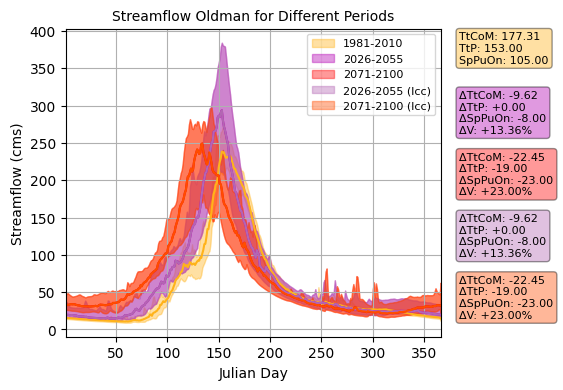

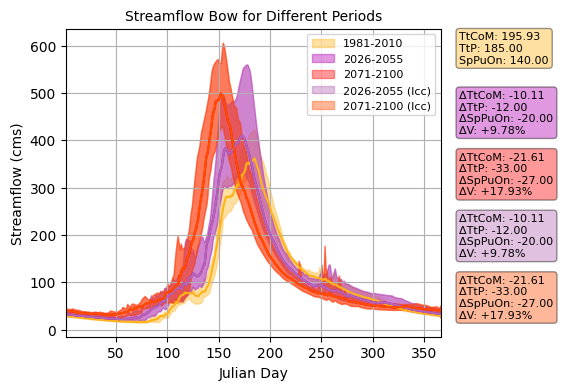

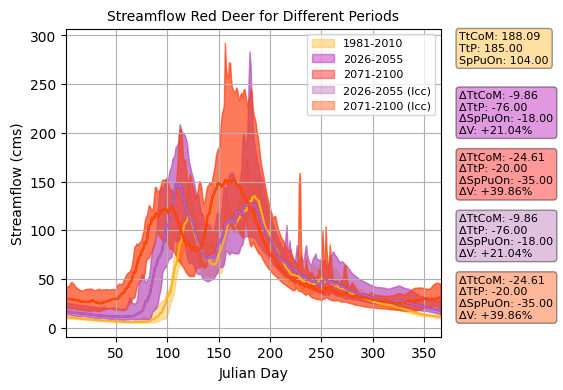

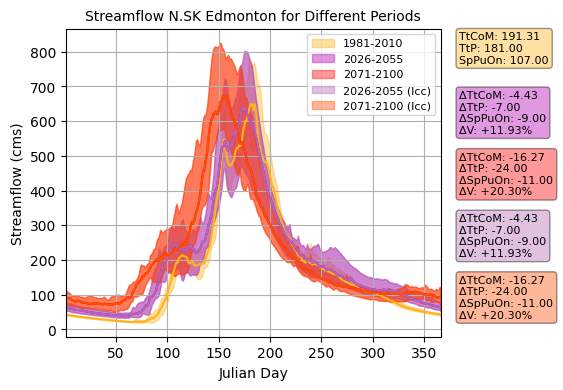

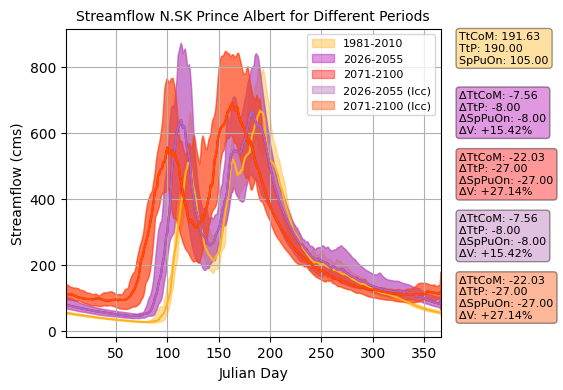

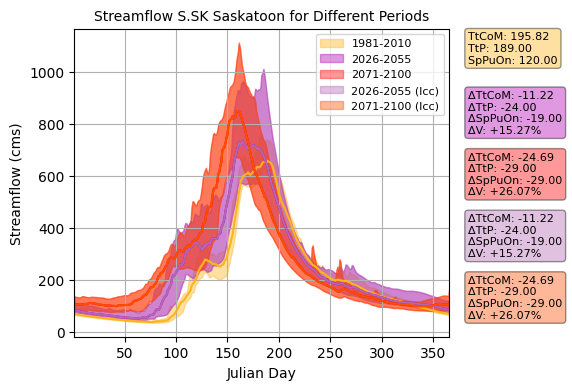

In [3]:
# Plotting for each station in station_list
for station, station_name in zip(station_list, station_names):
    min_1981_2010, max_1981_2010, median_1981_2010 = calculate_min_max_median(df_1981_2010, station)
    min_2026_2055, max_2026_2055, median_2026_2055 = calculate_min_max_median(df_2026_2055, station)
    min_2071_2100, max_2071_2100, median_2071_2100 = calculate_min_max_median(df_2071_2100, station)
    min_2026_2055_lcc, max_2026_2055_lcc, median_2026_2055_lcc = calculate_min_max_median(df_2026_2055_lcc, station)
    min_2071_2100_lcc, max_2071_2100_lcc, median_2071_2100_lcc = calculate_min_max_median(df_2071_2100_lcc, station)
    
    metrics_station = calculate_metrics_for_median(median_1981_2010, median_2026_2055, median_2071_2100, median_2026_2055_lcc, median_2071_2100_lcc)
    
    # Calculate the relative change in median volume
    total_volume_1981_2010 = median_1981_2010.sum()
    total_volume_2026_2055 = median_2026_2055.sum()
    total_volume_2071_2100 = median_2071_2100.sum()
    total_volume_2026_2055_lcc = median_2026_2055_lcc.sum()
    total_volume_2071_2100_lcc = median_2071_2100_lcc.sum()
    
    delta_v_2026_2055 = (total_volume_2026_2055 - total_volume_1981_2010) / total_volume_1981_2010 * 100
    delta_v_2071_2100 = (total_volume_2071_2100 - total_volume_1981_2010) / total_volume_1981_2010 * 100
    delta_v_2026_2055_lcc = (total_volume_2026_2055_lcc - total_volume_1981_2010) / total_volume_1981_2010 * 100
    delta_v_2071_2100_lcc = (total_volume_2071_2100_lcc - total_volume_1981_2010) / total_volume_1981_2010 * 100
    
    plt.figure(figsize=(6, 4))

    # Plot for 1981-2010
    plt.fill_between(df_1981_2010.index, min_1981_2010, max_1981_2010, color=colors[0], alpha=0.40, label='1981-2010')
    plt.plot(df_1981_2010.index, median_1981_2010, color=colors[0])

    # Adjust plot margins to make space for annotations
    plt.subplots_adjust(right=0.75)

    # Annotate metrics for 1981-2010
    plt.annotate(f"TtCoM: {metrics_station['1981_2010']['TtCoM']:.2f}\nTtP: {metrics_station['1981_2010']['TtP']:.2f}\nSpPuOn: {metrics_station['1981_2010']['SpringPulseOnset']:.2f}", 
                 xy=(1.05, 0.99), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[0], alpha=0.4))

    # Plot for 2026-2055
    plt.fill_between(df_2026_2055.index, min_2026_2055, max_2026_2055, color=colors[1], alpha=0.40, label='2026-2055')
    plt.plot(df_2026_2055.index, median_2026_2055, color=colors[1])

    # Annotate differences for 2026-2055
    plt.annotate(f"ΔTtCoM: {metrics_station['2026_2055']['Diff_TtCoM']:+.2f}\nΔTtP: {metrics_station['2026_2055']['Diff_TtP']:+.2f}\nΔSpPuOn: {metrics_station['2026_2055']['Diff_SpringPulseOnset']:+.2f}\nΔV: {delta_v_2026_2055:+.2f}%", 
                 xy=(1.05, 0.80), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[1], alpha=0.4))

    # Plot for 2071-2100
    plt.fill_between(df_2071_2100.index, min_2071_2100, max_2071_2100, color=colors[2], alpha=0.40, label='2071-2100')
    plt.plot(df_2071_2100.index, median_2071_2100, color=colors[2])

    # Annotate differences for 2071-2100
    plt.annotate(f"ΔTtCoM: {metrics_station['2071_2100']['Diff_TtCoM']:+.2f}\nΔTtP: {metrics_station['2071_2100']['Diff_TtP']:+.2f}\nΔSpPuOn: {metrics_station['2071_2100']['Diff_SpringPulseOnset']:+.2f}\nΔV: {delta_v_2071_2100:+.2f}%", 
                 xy=(1.05, 0.60), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[2], alpha=0.4))

    # Plot for 2026-2055 (lcc)
    plt.fill_between(df_2026_2055_lcc.index, min_2026_2055_lcc, max_2026_2055_lcc, color=colors[3], alpha=0.40, label='2026-2055 (lcc)')
    plt.plot(df_2026_2055_lcc.index, median_2026_2055_lcc, color=colors[3])

    # Annotate differences for 2026-2055 (lcc)
    plt.annotate(f"ΔTtCoM: {metrics_station['2026_2055_lcc']['Diff_TtCoM']:+.2f}\nΔTtP: {metrics_station['2026_2055_lcc']['Diff_TtP']:+.2f}\nΔSpPuOn: {metrics_station['2026_2055_lcc']['Diff_SpringPulseOnset']:+.2f}\nΔV: {delta_v_2026_2055_lcc:+.2f}%", 
                 xy=(1.05, 0.40), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[3], alpha=0.4))

    # Plot for 2071-2100 (lcc)
    plt.fill_between(df_2071_2100_lcc.index, min_2071_2100_lcc, max_2071_2100_lcc, color=colors[4], alpha=0.40, label='2071-2100 (lcc)')
    plt.plot(df_2071_2100_lcc.index, median_2071_2100_lcc, color=colors[4])

    # Annotate differences for 2071-2100 (lcc)
    plt.annotate(f"ΔTtCoM: {metrics_station['2071_2100_lcc']['Diff_TtCoM']:+.2f}\nΔTtP: {metrics_station['2071_2100_lcc']['Diff_TtP']:+.2f}\nΔSpPuOn: {metrics_station['2071_2100_lcc']['Diff_SpringPulseOnset']:+.2f}\nΔV: {delta_v_2071_2100_lcc:+.2f}%", 
                 xy=(1.05, 0.20), xycoords='axes fraction', fontsize=annotation_fontsize, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor=colors[4], alpha=0.4))

    plt.xlabel('Julian Day', fontsize=label_fontsize)
    plt.ylabel(f'Streamflow (cms)', fontsize=label_fontsize)
    plt.title(f'Streamflow {station_name} for Different Periods', fontsize=title_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True)
    plt.xlim(1, 366)  # Set x-axis limits from 1 to 366
    
    # Save the figure
    plt.savefig(os.path.join(output_directory, f"{station_name}_streamflow.png"), bbox_inches='tight')
    # Display the plot
    plt.show()